# Using NLTK to Process DNS Records

We will now use NTLK (the natural language toolkit) to process just the DNS Records

In [1]:
from pathlib import Path
import os
import re
import apsw
import pandas as pd
import time


The following query relies on the existence of the following view in the database
<code>
    
    create view v_sessionid_session_durn as
    select d.sessionid, max(d.frameTime) - min(d.frameTime) as session_durn from deviceLog d group by d.sessionid;
        
    create view if not exists v_pktnum_dnsq_sessionid as
        select q.pktnum, q.dnsquery, d.sessionid, d.manufacturer, d.device_type, d.frameTTL, vssd.session_durn
        from dnsqueries q
                 inner join deviceLog d on q.pktnum = d.frameNum
              inner join v_sessionid_session_durn vssd on d.sessionid = vssd.sessionid;
</code>

In [2]:
cwd = Path.cwd()
db_path = os.path.join(cwd.parent, 'Data', 'NetCollector.sqlite')


In [3]:
from sqlalchemy import create_engine
engine = create_engine(f'sqlite:////{db_path}')

print(engine)

sql = """

select s.srcport,
       s.dstport,
       s.lensum,
       s.pktcount,
       vpds.session_durn,
       vpds.framettl,
       vpds.dnsquery,
       vpds.manufacturer,
       vpds.device_type
from sessions s
         inner join v_pktnum_dnsq_sessionid vpds on s.sessionid = vpds.sessionid
            where vpds.device_type is not null

"""

df = pd.read_sql_query(sql, engine)


Engine(sqlite://///home/ricdeez/uni/NetCollector/Data/NetCollector.sqlite)


In [4]:
df


srcport dstport  lensum  pktcount  session_durn  frameTTL  \
0      61582      53      90         1      0.000000        64   
1      62388      53      90         1      0.000000        64   
2       5353    5353  218498      1256      0.727578       255   
3       5000   63768     859         6   5937.050198       255   
4       5000   63768     859         6   5937.050198       255   
...      ...     ...     ...       ...           ...       ...   
5813    5000   63768     859         6   5937.050198       255   
5814    5000   63768     859         6   5937.050198       255   
5815    5000   63768     859         6   5937.050198       255   
5816   48920     123      90         1  51300.590215        64   
5817   57303      53     108         1      0.000000        64   

                           dnsquery               manufacturer    device_type  
0                       Dan-PC.lan.  AzureWave Technology Inc.          Other  
1                       Dan-PC.lan.  AzureWave Technology Inc.          Other  
2                     Dan-PC.local.  AzureWave Technology Inc.         Laptop  
3                     Dan-PC.local.  AzureWave Technology Inc.         Laptop  
4                     Dan-PC.local.  AzureWave Technology Inc.         Laptop  
...                             ...                        ...            ...  
5813              _migo._tcp.local.  AzureWave Technology Inc.         Laptop  
5814              _migo._tcp.local.  AzureWave Technology Inc.         Laptop  
5815              _migo._tcp.local.  AzureWave Technology Inc.         Laptop  
5816               sip.invoxia.com.                             Triby Speaker  
5817  scontent-syd1-1.xx.fbcdn.net.  AzureWave Technology Inc.          Other  

[5818 rows x 9 columns]

In [5]:
from keras.preprocessing.text import Tokenizer


Using TensorFlow backend.


In [6]:
dns = df['dnsquery']

In [7]:
tk = Tokenizer()
tk.fit_on_texts(dns)
# https://github.com/keras-team/keras/issues/8092
num_words = 20
tk.word_index = {e:i for e,i in tk.word_index.items() if i < num_words} 

In [8]:
encoded_dns=tk.texts_to_matrix(dns, mode='binary')

In [9]:
cols = [f'word_idx{i+1}' for i in range(num_words)]

In [10]:
df2 = pd.DataFrame(data=encoded_dns, columns=cols)

In [11]:
df = pd.concat([df, df2], axis='columns')

In [12]:
df

srcport dstport  lensum  pktcount  session_durn  frameTTL  \
0      61582      53      90         1      0.000000        64   
1      62388      53      90         1      0.000000        64   
2       5353    5353  218498      1256      0.727578       255   
3       5000   63768     859         6   5937.050198       255   
4       5000   63768     859         6   5937.050198       255   
...      ...     ...     ...       ...           ...       ...   
5813    5000   63768     859         6   5937.050198       255   
5814    5000   63768     859         6   5937.050198       255   
5815    5000   63768     859         6   5937.050198       255   
5816   48920     123      90         1  51300.590215        64   
5817   57303      53     108         1      0.000000        64   

                           dnsquery               manufacturer    device_type  \
0                       Dan-PC.lan.  AzureWave Technology Inc.          Other   
1                       Dan-PC.lan.  AzureWave Technology Inc.          Other   
2                     Dan-PC.local.  AzureWave Technology Inc.         Laptop   
3                     Dan-PC.local.  AzureWave Technology Inc.         Laptop   
4                     Dan-PC.local.  AzureWave Technology Inc.         Laptop   
...                             ...                        ...            ...   
5813              _migo._tcp.local.  AzureWave Technology Inc.         Laptop   
5814              _migo._tcp.local.  AzureWave Technology Inc.         Laptop   
5815              _migo._tcp.local.  AzureWave Technology Inc.         Laptop   
5816               sip.invoxia.com.                             Triby Speaker   
5817  scontent-syd1-1.xx.fbcdn.net.  AzureWave Technology Inc.          Other   

      word_idx1  ...  word_idx191  word_idx192  word_idx193  word_idx194  \
0           0.0  ...          0.0          0.0          0.0          0.0   
1           0.0  ...          0.0          0.0          0.0          0.0   
2           0.0  ...          0.0          0.0          0.0          0.0   
3           0.0  ...          0.0          0.0          0.0          0.0   
4           0.0  ...          0.0          0.0          0.0          0.0   
...         ...  ...          ...          ...          ...          ...   
5813        0.0  ...          0.0          0.0          0.0          0.0   
5814        0.0  ...          0.0          0.0          0.0          0.0   
5815        0.0  ...          0.0          0.0          0.0          0.0   
5816        0.0  ...          0.0          0.0          0.0          0.0   
5817        0.0  ...          0.0          0.0          0.0          0.0   

      word_idx195  word_idx196  word_idx197  word_idx198  word_idx199  \
0             0.0          0.0          0.0          0.0          0.0   
1             0.0          0.0          0.0          0.0          0.0   
2             0.0          0.0          0.0          0.0          0.0   
3             0.0          0.0          0.0          0.0          0.0   
4             0.0          0.0          0.0          0.0          0.0   
...           ...          ...          ...          ...          ...   
5813          0.0          0.0          0.0          0.0          0.0   
5814          0.0          0.0          0.0          0.0          0.0   
5815          0.0          0.0          0.0          0.0          0.0   
5816          0.0          0.0          0.0          0.0          0.0   
5817          0.0          0.0          0.0          0.0          0.0   

      word_idx200  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
5813          0.0  
5814          0.0  
5815          0.0  
5816          0.0  
5817          0.0  

[5818 rows x 209 columns]

In [13]:
import numpy as np
df['is_iot'] = np.where(df['device_type'] == 'Other', 0, 1)
df['dstport_is_53'] = np.where(df['dstport'] == '53', 1, 0)
df['dstport_is_5353'] = np.where(df['dstport'] == '5353', 1, 0)
df['dstport_is_5353'] = np.where(df['dstport'] == '5353', 1, 0)
df['dstport_is_other'] = np.where(((df['dstport'] != '5353') & (df['dstport'] != '53')), 1, 0)


In [14]:
# df['srcport_is_5353'] = np.where(df['srcport'] == '5353', 1, 0) -- dropped since highly correlated!
df['srcport_is_443'] = np.where(df['srcport'] == '443', 1, 0)
df['srcport_is_8080'] = np.where(df['srcport'] == '8080', 1, 0)
df['srcport_is_other'] = np.where((\
                                  (df['srcport'] != '5353') & \
                                  (df['srcport'] != '443') & \
                                  (df['srcport'] != '8080'))\
                                  , 1, 0)

In [15]:
drop_columns = ['srcport', 'dstport', 'device_type']

In [16]:
df.drop(drop_columns, axis='columns', inplace=True)

In [17]:
df.drop('dnsquery', axis='columns', inplace=True)

In [18]:
mapping = {k: v for v, k in enumerate((x for x in df['manufacturer'].unique() if len(x)>0),1)}
print(mapping)

{'AzureWave Technology Inc.': 1, 'Unknown': 2, 'Samsung Electronics Co.,Ltd': 3, 'HTC Corporation': 4, 'Lifi Labs Management Pty Ltd': 5, 'Amazon Technologies Inc.': 6, 'Belkin International Inc.': 7, 'Physical Graph Corporation': 8}


**Categorical data mapping**

For the deep learning algorithm to work, we need to get rid of all categorical data.  For the Manufacturer's we will create a 1:1 mapping of the manufacturer name as per the wireshark OUI lookup dataset and the relative
position of that in our ordered array of unique entries

In [19]:
df['manufacturer'] = df['manufacturer'].map(mapping)

In [20]:
df.head()

lensum  pktcount  session_durn  frameTTL  manufacturer  word_idx1  \
0      90         1      0.000000        64           1.0        0.0   
1      90         1      0.000000        64           1.0        0.0   
2  218498      1256      0.727578       255           1.0        0.0   
3     859         6   5937.050198       255           1.0        0.0   
4     859         6   5937.050198       255           1.0        0.0   

   word_idx2  word_idx3  word_idx4  word_idx5  ...  word_idx198  word_idx199  \
0        0.0        0.0        0.0        0.0  ...          0.0          0.0   
1        0.0        0.0        0.0        0.0  ...          0.0          0.0   
2        0.0        0.0        0.0        0.0  ...          0.0          0.0   
3        0.0        0.0        0.0        0.0  ...          0.0          0.0   
4        0.0        0.0        0.0        0.0  ...          0.0          0.0   

   word_idx200  is_iot  dstport_is_53  dstport_is_5353  dstport_is_other  \
0          0.0       0              1                0                 0   
1          0.0       0              1                0                 0   
2          0.0       1              0                1                 0   
3          0.0       1              0                0                 1   
4          0.0       1              0                0                 1   

   srcport_is_443  srcport_is_8080  srcport_is_other  
0               0                0                 1  
1               0                0                 1  
2               0                0                 0  
3               0                0                 1  
4               0                0                 1  

[5 rows x 212 columns]

In [21]:
features = ['lensum', 'pktcount', 'session_durn', 'frameTTL']
for feature in features:
    df[feature] = (df[feature] - df[feature].mean()) / \
        (df[feature].max() - df[feature].min())

In [22]:
df.head()

lensum  pktcount  session_durn  frameTTL  manufacturer  word_idx1  \
0 -0.001817 -0.001527     -0.086015 -0.162646           1.0        0.0   
1 -0.001817 -0.001527     -0.086015 -0.162646           1.0        0.0   
2  0.998083  0.998473     -0.086001  0.589322           1.0        0.0   
3  0.001704  0.002457      0.028382  0.589322           1.0        0.0   
4  0.001704  0.002457      0.028382  0.589322           1.0        0.0   

   word_idx2  word_idx3  word_idx4  word_idx5  ...  word_idx198  word_idx199  \
0        0.0        0.0        0.0        0.0  ...          0.0          0.0   
1        0.0        0.0        0.0        0.0  ...          0.0          0.0   
2        0.0        0.0        0.0        0.0  ...          0.0          0.0   
3        0.0        0.0        0.0        0.0  ...          0.0          0.0   
4        0.0        0.0        0.0        0.0  ...          0.0          0.0   

   word_idx200  is_iot  dstport_is_53  dstport_is_5353  dstport_is_other  \
0          0.0       0              1                0                 0   
1          0.0       0              1                0                 0   
2          0.0       1              0                1                 0   
3          0.0       1              0                0                 1   
4          0.0       1              0                0                 1   

   srcport_is_443  srcport_is_8080  srcport_is_other  
0               0                0                 1  
1               0                0                 1  
2               0                0                 0  
3               0                0                 1  
4               0                0                 1  

[5 rows x 212 columns]

# the fun starts here...

Firstly, we will try to see if we can converge our model, we'll split the dataset as follows:

1. Training set (80%)
2. Test set (20%)
3. We have not set up a validation set as we will continue to validate the model against new captures


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
features = df.drop('is_iot', axis=1).values

In [25]:
labels = df['is_iot'].values

In [26]:
df.shape[1]

212

In [27]:
features.shape[1]

211

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [29]:
print(len(labels), len(Y_train), len(Y_test), sep='::')

5818::4654::1164


# Classification Problems

*A quick recap of the various hyper-parameters to be used in the model for each type of classification problem:*

**Binary Classification Problem**

A problem where you classify an example as belonging to one of two classes.

The problem is framed as predicting the likelihood of an example belonging to class one, e.g. the class that you assign the integer value 1, whereas the other class is assigned the value 0.

 - Output Layer Configuration: `One node with a sigmoid activation unit`.
 - Loss Function: `Cross-Entropy`, also referred to as Logarithmic loss.

**Multi-Class Classification Problem**

A problem where you classify an example as belonging to one of more than two classes.

The problem is framed as predicting the likelihood of an example belonging to each class.

 - Output Layer Configuration: `One node for each class using the softmax activation function`.
 - Loss Function: `Cross-Entropy`, also referred to as Logarithmic loss.

In [30]:
from keras.models import Sequential
from keras.layers import *
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform


In [31]:
model = Sequential()
model.add(Dense(32, input_dim=features.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=['accuracy'])
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [32]:
history = model.fit(X_train, Y_train, epochs=60, batch_size=10, shuffle=True, verbose=2)

Epoch 1/60
 - 0s - loss: nan - accuracy: 0.0026
Epoch 2/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 3/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 4/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 5/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 6/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 7/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 8/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 9/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 10/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 11/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 12/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 13/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 14/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 15/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 16/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 17/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 18/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 19/60
 - 0s - loss: nan - accuracy: 0.0000e+00
Epoch 

# Cross-Entropy Loss (or Log Loss)


Cross-entropy loss is often simply referred to as “cross-entropy,” “logarithmic loss,” “logistic loss,” or 
“log loss” for short.

Each predicted probability is compared to the actual class output value (0 or 1) and a score is calculated that 
penalizes the probability based on the distance from the expected value. The penalty is logarithmic, 
offering a small score for small differences (0.1 or 0.2) and enormous score for a large difference (0.9 or 1.0).

Cross-entropy loss is minimized, where smaller values represent a better model than larger values. 
A model that predicts perfect probabilities has a cross entropy or log loss of 0.0.

Cross-entropy for a binary or two class prediction problem is actually calculated as the average 
cross entropy across all examples.

The Python function below provides a pseudocode-like working implementation of a function for calculating 
the cross-entropy for a list of actual 0 and 1 values compared to predicted probabilities for the class 1.

<code>
from math import log

def binary_cross_entropy(actual, predicted):
	sum_score = 0.0
	for i in range(len(actual)):
		sum_score += actual[i] * log(1e-15 + predicted[i])
	mean_sum_score = 1.0 / len(actual) * sum_score
	return -mean_sum_score
</code>

In [33]:
model.metrics_names

['loss', 'accuracy']

In [34]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)

In [35]:
print(f'Loss = {loss}, Accuracy={accuracy}')

Loss = nan, Accuracy=0.0


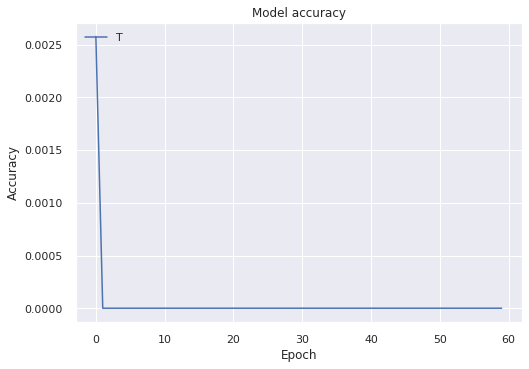

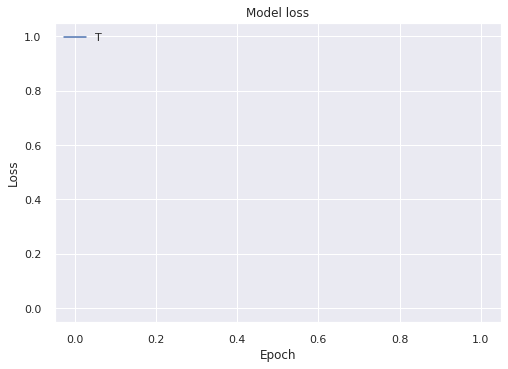

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend('Train', loc='upper left')
plt.show()

# # Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend('Train', loc='upper left')
plt.show()

In [39]:
import pandas_profiling
pandas_profiling.ProfileReport(df)